# ULMFit

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_12a import *

## Data

In [3]:
path = datasets.untar_data(datasets.URLs.IMDB)

In [4]:
ll = pickle.load(open(path/'ll_lm.pkl', 'rb'))

In [5]:
bs, bptt = 64, 70

In [6]:
data = lm_databunchify(ll, bs, bptt)

In [7]:
vocab = ll.train.proc_x[1].vocab

## Finetuing the LM

In [11]:
dps = tensor([0.1, 0.15, 0.25, 0.02, 0.2]) * 0.5

In [12]:
tok_pad = vocab.index(PAD)

In [13]:
emb_sz, nh, nl = 300, 300, 2

In [14]:
model = get_language_model(len(vocab), emb_sz, nh, nl, tok_pad, *dps)

In [15]:
old_wgts = torch.load(path/'pretrained'/'pretrained.pth')

In [16]:
old_vocab = pickle.load(open(path/'pretrained'/'vocab.pkl', 'rb'))

The ids in the vocab depend on the token frequency in the corpus. We have to match the new (IMDB) vocab to the old (WT103) corpus.

In [17]:
idx_house_new, idx_house_old = vocab.index('house'), old_vocab.index('house')

In [18]:
idx_house_new, idx_house_old

(348, 230)

We have to match the embedding and the decoder weights accordingly. For tokens that did not exist in the old vocabulary and, thus, in the embedding, we use the mean of the pretrained embedding weights/decoder bias.

In [19]:
house_wgt = old_wgts['0.emb.weight'][idx_house_old]
house_bias= old_wgts['1.decoder.bias'][idx_house_old]

In [20]:
house_wgt.shape, house_bias

(torch.Size([300]), tensor(0.1079, device='cuda:0'))

In [21]:
old_wgts['0.emb.weight'].shape, old_wgts['1.decoder.bias'].shape

(torch.Size([60002, 300]), torch.Size([60002]))

In [22]:
def match_embeds(old_wgts, old_vocab, new_vocab):
    wgts = old_wgts['0.emb.weight']
    bias = old_wgts['1.decoder.bias']
    wgts_m, bias_m = wgts.mean(dim=0), bias.mean()

    new_wgts = wgts.new_zeros(len(new_vocab), wgts.size(1))
    new_bias = bias.new_zeros(len(vocab))
    
    otoi = {v:k for k,v in enumerate(old_vocab)}
    
    for i, w in enumerate(new_vocab):
        if w in otoi:
            idx = otoi[w]  # old idx
            new_wgts[i], new_bias[i] = wgts[idx], bias[idx]
        else:
            new_wgts[i], new_bias[i] = wgts_m, bias_m
        
    old_wgts['0.emb.weight'] = new_wgts
    old_wgts['0.emb_dp.emb.weight'] = new_wgts
    old_wgts['1.decoder.weight']    = new_wgts  # weight tying
    old_wgts['1.decoder.bias']      = new_bias
    
    return old_wgts

In [23]:
wgts = match_embeds(old_wgts, old_vocab, vocab)

Let's check that the token "house" was properly converted:

In [24]:
test_near(wgts['0.emb.weight'][idx_house_new], house_wgt)

In [25]:
test_near(wgts['1.decoder.bias'][idx_house_new], house_bias)

Load pretrained weights into our model

In [26]:
model.load_state_dict(wgts);

In [27]:
model

SequentialRNN(
  (0): AWD_LSTM(
    (emb): Embedding(60002, 300, padding_idx=1)
    (emb_dp): EmbeddingDropout(
      (emb): Embedding(60002, 300, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(300, 300, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(300, 300, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (output_dp): RNNDropout()
    (decoder): Linear(in_features=300, out_features=60002, bias=True)
  )
)

We want to apply discriminative learning rates. In order to do so, we have to split our model in different layer groups:

We split the rnn/corresponding dropouts into two groups plus one additional group for the embeddings/decoder. The latter has to be trained the most because of the new embedding vectors.

In [28]:
def lm_splitter(m):
    groups = []
    for i in range(len(m[0].rnns)):
        groups.append(nn.Sequential(m[0].rnns[i], m[0].hidden_dps[i]))
    groups += [nn.Sequential(m[0].emb, m[0].emb_dp, m[0].input_dp, m[1])]

    return [list(o.parameters()) for o in groups]

First, we freeze the RNNs:

In [29]:
for rnn in model[0].rnns:
    for p in rnn.parameters():
        p.requires_grad_(False)

In [30]:
cbs = [partial(AvgStatsCallback, accuracy_flat),
       CudaCallback, Recorder,
       partial(GradientClipping, clip=0.1),
       partial(RNNTrainer, alpha=2., beta=1.),
       ProgressCallback]

In [31]:
learn = Learner(model, data, cross_entropy_flat, opt_func=adam_opt(), cb_funcs=cbs, splitter=lm_splitter)

In [32]:
lr = 2e-2

In [33]:
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                 for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [34]:
cbsched = sched_1cycle([lr], pct_start=0.5, mom_start=0.8, mom_mid=0.7, mom_end=0.8)

In [35]:
learn.fit(1, cbs=cbsched)

epoch,train_loss,train_accuracy_flat,valid_loss,valid_accuracy_flat,time
0,4.489993,0.245784,4.282488,0.262626,13:49


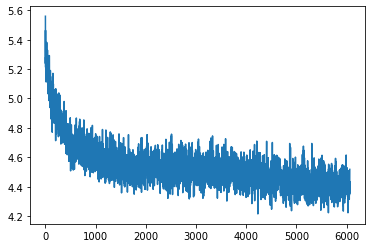

In [36]:
learn.recorder.plot_loss()

Then the entire model with discriminative learning rates:

In [37]:
for rnn in model[0].rnns:
    for p in rnn.parameters():
        p.requires_grad_(False)

In [38]:
lr = 2e-3

In [39]:
cbsched = sched_1cycle([lr/2., lr/2., lr], pct_start=0.5, mom_start=0.8, mom_mid=0.7, mom_end=0.8)

In [40]:
learn.fit(1, cbs=cbsched)

epoch,train_loss,train_accuracy_flat,valid_loss,valid_accuracy_flat,time
0,4.294751,0.257910,4.258042,0.264417,13:50


We save the encoder and the vocab for classification.

In [41]:
torch.save(learn.model[0].state_dict(), path/'finetuned_enc.pth')

In [42]:
pickle.dump(vocab, open(path/'vocab_lm.pkl', 'wb'))

In [43]:
torch.save(learn.model.state_dict(), path/'finetuned.pth')

## Classifier